In [4]:
from ngsolve import *
from netgen.geom2d import *

import numpy 
import scipy.linalg
import scipy.sparse as sp

from netgen.occ import *

from helping_functions import *

from ngsolve.webgui import Draw
import matplotlib.pyplot as plt


In [5]:
# DOMAIN CONSTRUCTION Omega = B1(0)
# Division in 8 subdomains

geo = SplineGeometry()
Points = [(0,-1), (1,-1), (1,0), 
          (1,1), (0,1), (-1,1),
          (-1,0), (-1,-1), (0,0)]

bcs_edge = ["c0", "c1", "c2", "c3", 
            "m0", "m1", "m2", "m3",
            "m4", "m5", "m6", "m7"]

for i, pnt in enumerate(Points):
    geo.AddPoint(*pnt, name = "V" + str(i))

geo.Append(["spline3", 0, 1, 2], leftdomain=1, rightdomain=0, bc="c0")
geo.Append(["spline3", 2, 3, 4], leftdomain=2, rightdomain=0, bc="c1")
geo.Append(["spline3", 4, 5, 6], leftdomain=3, rightdomain=0, bc="c2")
geo.Append(["spline3", 6, 7, 0], leftdomain=4, rightdomain=0, bc="c3")
geo.Append(["line", 0, 2], leftdomain=5, rightdomain=1, bc="m0")
geo.Append(["line", 2, 4], leftdomain=6, rightdomain=2, bc="m1")
geo.Append(["line", 4, 6], leftdomain=7, rightdomain=3, bc="m2")
geo.Append(["line", 6, 0], leftdomain=8, rightdomain=4, bc="m3")

geo.Append(["line", 8, 0], leftdomain=5, rightdomain=8, bc="m4")
geo.Append(["line", 8, 2], leftdomain=6, rightdomain=5, bc="m5")
geo.Append(["line", 8, 4], leftdomain=7, rightdomain=6, bc="m6")
geo.Append(["line", 8, 6], leftdomain=8, rightdomain=7, bc="m7")

# geo = SplineGeometry()
# geo.AddCircle ( (0, 0), r=1, leftdomain=1, rightdomain=0, )
ngmesh = geo.GenerateMesh(maxh= 0.08) #Too much 0.0013




mesh = Mesh(ngmesh)
for i in range(8):
    mesh.ngmesh.SetMaterial(i+1,"om" + str(i))

#Draw(mesh)
print(mesh.nv)
# quit()
print(mesh.GetMaterials())
print(mesh.GetBoundaries())
print(mesh.GetBBoundaries())
# input()

dom_bnd = "c0|c1|c2|c3"



621
('om0', 'om1', 'om2', 'om3', 'om4', 'om5', 'om6', 'om7')
('c0', 'c1', 'c2', 'c3', 'm0', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7')
('V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8')


**Helmholtz problem description - Plane wave**

$- div (a \nabla u) - k^2 u  = f$ in $\Omega = B_1(0)$,

$ a \partial_n u - i \omega \beta u = g $ on $\partial \Omega = \Gamma_R$. 


In this example we have:

$a=1$, 

$c=1$, 

$\beta=1$, 

$\omega=2$, 

$k = \omega (0.6,0.8)$,

$f=0$,

$g= -i \left((0.6 x + 0.8 y) + \beta \right) \exp^{-i (0.6 x + 0.8 y)}$

$u_{ex} = \exp^{-i (0.6 x + 0.8 y)}$.

In [6]:
#g = exp(-200 * ( (x+1/sqrt(2))**2 + (y-1/sqrt(2))**2))

# f = exp(-200 * ( (x)**2 + (y)**2))
# u_ex = exp(-1J * (k[0] * x + k[1] * y))

#Draw(g.real, mesh, "u_ex")
#Draw(g.imag, mesh, "u_ex")
#c = 1
#kappa = 16

In [ ]:
#Problem setting - PLANE WAVE

omega = 1


# k = CF((0.6,0.8)) #CF = CoefficientFunction
# kappa = omega * k
kappa = omega
k = kappa * np.array([0.6,0.8])
beta = 1
f = 0
# u_ex = exp(-1J * (k[0] * x + k[1] * y))
# g = -1j * omega * (k[0] * x + k[1] * y) * u_ex - 1j *beta * u_ex
g = 1j * exp(-200 * ( (x+1/sqrt(2))**2 + (y-1/sqrt(2))**2))




**Helmholtz problem description - Interior source**

$- div (a \nabla u) - k^2 u  = f$ in $\Omega = B_1(0)$,

$ a \partial_n u - i \omega \beta u = g $ on $\partial \Omega = \Gamma_R$. 


In this example we have:

$a=1$, 

$c=1$, 

$\beta=1$, 

$\omega=1$, 

$k = \omega$,

$f=\exp{-200 |x-x_c|}$, with $x_c = (1/3,1/3)$,

$g= 0$.

In [15]:
#Problem setting - INTERIOR SOURCE

omega = 1
kappa = omega
beta = 1
p = (1/3, 1/3)
f = exp(-200 * x**2 ) #To do 
g = 0


In [34]:
# Coefficients

order_v = [2,3] # ATTENTION: There is an error for order=1
             # Cannot use scipy.linalg.eig for sparse A with k >= N - 1.
    
Bubble_modes = [2,32,128]
Edge_modes = [2,16]#,32,64,128,256] #[24; 28; : : : ; 3072] #We have 12 edges
max_bm = Bubble_modes[-1]
max_em = Edge_modes[-1]


In [35]:
h1_error = []
dofs =[]


for order in order_v:
    print(order)
    V = H1(mesh, order = order, complex = True)
    u, v = V.TnT()


    a = BilinearForm(V)
    a += grad(u) * grad(v) * dx() 
    a += - kappa**2 * u * v * dx()  
    a += -1J * omega * beta * u * v * ds(dom_bnd)
    a.Assemble()

    l = LinearForm(V)
    l += f * v * dx() #Not necessary because f = 0 in this example
    l += g * v * ds(dom_bnd)
    l.Assemble()

    gfu_ex = GridFunction(V)
    ainv = a.mat.Inverse(V.FreeDofs(), inverse = "sparsecholesky")
    gfu_ex.vec.data = ainv * l.vec
    print("FEM finished")
    gfu = GridFunction(V)
    
    #Computing full basis with max number of modes 
    acms = ACMS(order = order, mesh = mesh, bm = max_bm, em = max_em)
    
    
    acms.CalcHarmonicExtensions(kappa = kappa)
    acms.calc_basis()

#     Draw(gfu_ex, mesh, "u_fem")
    

    for EM in Edge_modes:
            for BM in Bubble_modes:
                #Vc = H1(mesh, order = order, complex = True)
                gfu = GridFunction(V)
                basis = MultiVector(gfu.vec, 0)
                
                for bv in acms.basis_v:
                    gfu.vec[:] = 0
                    gfu.vec.FV()[:] = bv
                    basis.Append(gfu.vec)
                
                for e, label in enumerate(mesh.GetBoundaries()):
                    for i in range(EM):
                        #gfu.vec[:] = 0
                        gfu.vec.FV()[:] = acms.basis_e[e * max_em + i]
                        basis.Append(gfu.vec)
        
                for d, dom in enumerate(mesh.GetMaterials()):
                    for i in range(BM):
                        gfu.vec.FV()[:] = acms.basis_b[d * max_bm + i]
                        basis.Append(gfu.vec)

    
                num = len(basis)
                dofs.append(num)
            
                asmall = np.zeros((num, num), dtype=numpy.complex128)
                asmall = InnerProduct (basis, a.mat * basis, conjugate = False) #Complex
                
                      
                asmall_np = np.zeros((num, num), dtype=numpy.complex128)
                asmall_np = asmall.NumPy()
    
                ainvs_small_np = np.zeros((num, num), dtype=numpy.complex128)
                ainvs_small_np = numpy.linalg.inv(asmall_np)

                ainvsmall = np.zeros((num, num), dtype=numpy.complex128)
                ainvsmall = Matrix(num,num, complex=True)


                for i in range(num):
                    for j in range(num):
                        ainvsmall[i,j] = ainvs_small_np[i,j]
                 
                f_small = []
                usmall = []
                
                f_small = InnerProduct(basis, l.vec)
                
                usmall = ainvsmall * f_small
                
                gfu.vec[:] = 0.0
                gfu.vec.data = basis * usmall

                
#                 Draw(gfu-gfu_ex, mesh, "error")

                print("finished_acms")
    
                #Computing ERROR
        
                grad_uex = Grad(gfu_ex)
                diff = grad_uex - Grad(gfu)
                
                h1_error_aux = sqrt( Integrate ( InnerProduct(diff,diff), mesh, order = 15))
                #print(h1_error_aux)
                
                #Needs to do complex conjugate
                #Draw(gfu, mesh, "u_acms")
                h1_error.append(h1_error_aux.real)
            
            

h1_error = np.reshape(h1_error, (len(order_v)*len(Edge_modes), len(Bubble_modes)))
dofs = np.reshape(dofs, (len(order_v)*len(Edge_modes), len(Bubble_modes)))
print(h1_error)



2
FEM finished
finished_acms
finished_acms
finished_acms
finished_acms
finished_acms
finished_acms
3
FEM finished
finished_acms
finished_acms
finished_acms
finished_acms
finished_acms
finished_acms
[[0.01952182 0.01542677 0.01436876]
 [0.01330187 0.00584432 0.00162624]
 [0.01479254 0.00878791 0.00670747]
 [0.01338227 0.00613591 0.00232823]]


In [27]:
[[0.01952187 0.01797434 0.01670776]
 [0.01330193 0.01091542 0.00867754]]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2336812332.py, line 1)

Text(0.5, 0, 'Edge modes')

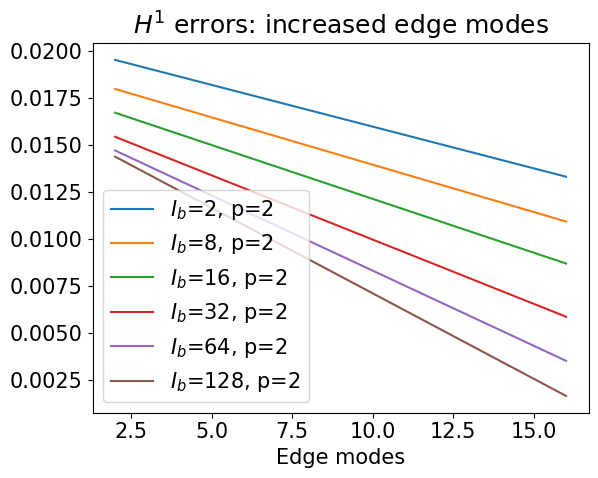

In [32]:
## PLOT ERROR with increased EDGE modes for different DEGREES of approximation
plt.rcParams.update({'font.size':15})
for d in range(len(order_v)):
    for i in range(len(Bubble_modes)):
        plt.plot(Edge_modes, h1_error[d*len(Edge_modes) : d*len(Edge_modes) + len(Edge_modes),i], label=('$I_b$=%i, p=%i' %(Bubble_modes[i],order_v[d])))
plt.title('$H^1$ errors: increased edge modes')
plt.legend()
plt.xlabel('Edge modes')

Text(0.5, 0, 'Bubbles')

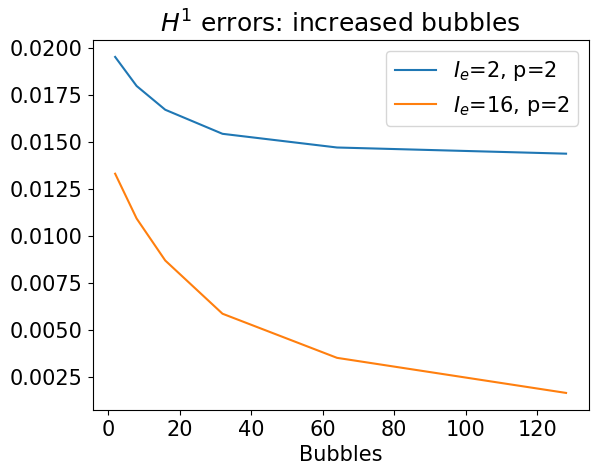

In [33]:
## PLOT ERROR with increased BUBBLE modes for different DEGREES of approximation
plt.rcParams.update({'font.size':15})
for d in range(len(order_v)):
    for i in range(len(Edge_modes)):
        plt.plot(Bubble_modes, h1_error[d*len(Edge_modes) + i,:], label=('$I_e$=%i, p=%i' %(Edge_modes[i],order_v[d])))
plt.title('$H^1$ errors: increased bubbles')
plt.legend()
plt.xlabel('Bubbles')

Old code for bubble and edge modes plots

In [ ]:
#Bubbles
plt.rcParams.update({'font.size':10})
for d in range(len(order_v)):
    for i in range(len(Edge_modes)):
        plt.loglog(Bubble_modes, h1_error[d*len(Edge_modes) + i,:], label=('Edge modes=%i' %Edge_modes[i]))
plt.title('$H^1$ errors: increased bubbles deg=%i' %order)
plt.legend()
plt.xlabel('Bubbles')



In [ ]:
#Edges
plt.rcParams.update({'font.size':10})
for d in range(len(order_v)):
    for i in range(len(Bubble_modes)):
        plt.loglog(dofs[d*len(Edge_modes):(d+1)*len(Edge_modes),i], h1_error[d*len(Edge_modes):(d+1)*len(Edge_modes),i], label=('Bubbles=%i' %Bubble_modes[i]))
plt.title('$H^1$ errors: increased edge modes deg=%i' %order)
plt.legend()
plt.xlabel('Edge modes / Dofs')
